In [432]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import figure
import matplotlib as mpl
import math
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
# Scikit-Learn imports
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [433]:
# Paramaters
ticker = "VZ"
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019,7,1)

In [434]:
# Collect stock prices for a set time period
df = web.DataReader(ticker, 'yahoo', start, end)

In [435]:
# Feature engineering
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open'])/ df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-06-26,56.396866,15042100.0,2.281107,-2.028531
2019-06-27,56.654160,9123300.0,0.908298,0.157453
2019-06-28,56.535412,14604000.0,1.050234,-0.157288
2019-07-01,56.070301,15830000.0,1.447229,-1.323578
2019-07-02,57.525002,14985700.0,2.305178,2.197609


In [436]:
# Create prediction
forecast_out = int(math.ceil(0.01 * len(dfreg)))
dfreg['prediction'] = dfreg['Adj Close'].shift(-forecast_out)

# Drop missing values
dfreg.fillna(value=-99999, inplace=True)

# Seperate Independent and dependent
X = np.array(dfreg.drop(['prediction'],1))
Y = np.array(dfreg['prediction'])

In [437]:
# Scale the X so that everyone can have the same distribution
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [438]:
# Find Date series of late and early X & Y
print(dfreg.describe())
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
print(len(X))

y = np.array(dfreg['prediction'])
y = y[:-forecast_out]
print(len(y))

         Adj Close        Volume       HL_PCT   PCT_change    prediction
count  2390.000000  2.390000e+03  2390.000000  2390.000000   2390.000000
mean     37.432765  1.623957e+07     1.456637     0.007131   -966.924998
std      10.243525  1.483047e+07     0.752844     0.894682   9976.201810
min      16.313293  3.375400e+06     0.352500    -4.938808 -99999.000000
25%      29.654418  1.134588e+07     0.992710    -0.517328     29.654418
50%      38.771534  1.410850e+07     1.305757     0.022113     38.771534
75%      44.396662  1.830448e+07     1.736741     0.530747     44.396662
max      59.632504  6.166205e+08    17.456409     3.457561     59.632504
2366
2366


In [439]:
# Split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [440]:
# Linear Regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=5)
clfknn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [441]:
# Evaluate
confidencereg = clfreg.score(X_test, Y_test)
confidenceply2 = clfpoly2.score(X_test, Y_test)
confidenceply3 = clfpoly3.score(X_test, Y_test)
confidenceknn = clfknn.score(X_test, Y_test)

regresssions = {
    'Linear Regression': clfreg,
    'Quadratic Regression 2nd Order': clfpoly2,
    'Quadratic Regression 3rd Order': clfpoly3,
    'KNN': clfknn
}

# Find the highest scoring regression
best_regression_score = 0
best_regression = None
best_regression_name = ''

for name, regression in regresssions.items():
    score = regression.score(X_test, Y_test)
    if(score > best_regression_score):
        best_regression = regression
        best_regression_score = score
        best_regression_name = name

In [442]:
# Print out the best regression
print("The best regression is %s" %(best_regression_name))

The best regression is Linear Regression


In [443]:
# Setup figure size
plt.rcParams["figure.figsize"] = [16,9]

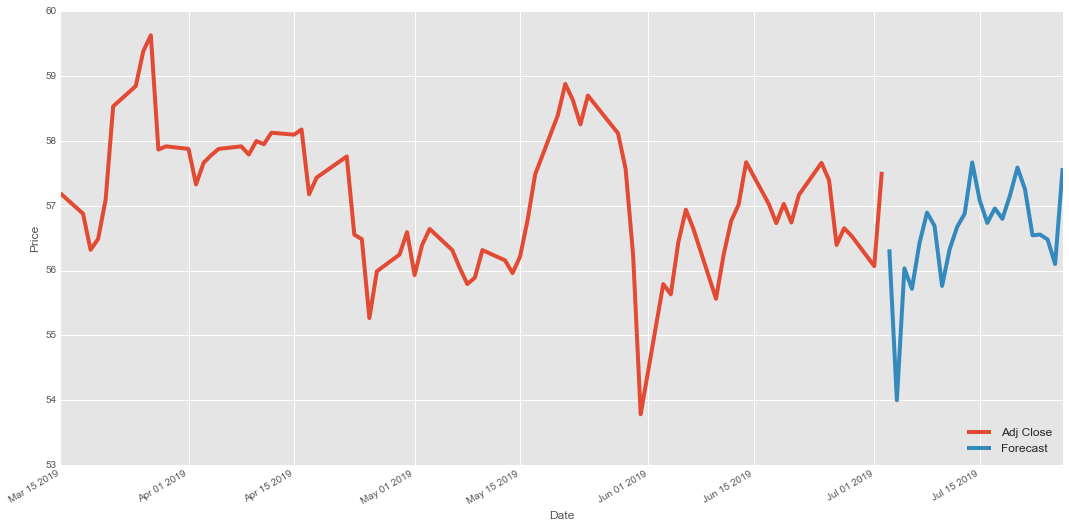

In [444]:
# Create forecast_set
forecast_set = best_regression.predict(X_lately)
dfreg['Forecast'] = np.nan

# Plot best prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)] +[i]
    
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()

# Adjusting the style of matplotlib
plt.style.use('ggplot')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()